# Volatility modelling: EWMA and GARCH

- Import the necessary packages 

|packages         |acronyms|
|-----------------|--------|
|matplotlib.pyplot| plt    |
|numpy            | np     |
|os               |        |
|pandas           | pd     |
|scipy.optimize   | spop   |

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os 
import pandas as pd 
import scipy.optimize as spop
import warnings

warnings.simplefilter('ignore')

- Set your working directory using <code>os.chdir([PATH])</code> (change directory).

In [2]:
#os.chdir(r'C:\Users\cdes1\OneDrive - ICHEC\Documents\Cours\PortfolioManagement')
os.chdir(r'/Users/christophe/OneDrive - ICHEC/Documents/Cours/PortfolioManagement')

- Check that the working directory has been updated (<code>os.getcwd()</code>). 

In [3]:
os.getcwd()

'/Users/christophe/Library/CloudStorage/OneDrive-ICHEC/Documents/Cours/PortfolioManagement'

## S&P500

- Import the excel File <code>sp500_daily.xlsx</code> (in your <code>data</code> folder) as a DataFrame called <code>df</code>.

In [4]:
df = pd.read_excel('data/sp500_daily.xlsx', index_col=0, parse_dates=True)

- Display the first 5 rows of this DataFrame (using <code>df.head()</code>). 

In [5]:
df.head()

CLOSE
Date             
1930-01-02  21.18
1930-01-03  21.23
1930-01-04  21.48
1930-01-06  21.50
1930-01-07  21.31

- Display the last 5 rows of this DataFrame (using <code>df.tail()</code>).

In [6]:
df.tail()

CLOSE
Date                 
2022-12-23  3844.8150
2022-12-27  3829.2493
2022-12-28  3783.2219
2022-12-29  3849.2832
2022-12-30  3839.4966

- Display some information about this DataFrame (using <code>df.info()</code>).

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 24060 entries, 1930-01-02 to 2022-12-30
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   CLOSE   24060 non-null  float64
dtypes: float64(1)
memory usage: 375.9 KB


- Rename the column "CLOSE" as "price". 

https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.rename.html

In [8]:
df.rename(columns={'CLOSE': 'price'}, inplace=True)
df

price
Date                 
1930-01-02    21.1800
1930-01-03    21.2300
1930-01-04    21.4800
1930-01-06    21.5000
1930-01-07    21.3100
...               ...
2022-12-23  3844.8150
2022-12-27  3829.2493
2022-12-28  3783.2219
2022-12-29  3849.2832
2022-12-30  3839.4966

[24060 rows x 1 columns]

### Line chart 

Create a line plot of the S&P500. 

Set a label <code>SP500</code> on the y-axis and a title (e.g., <code>'SP500 (1930-2022)'</code>) 

https://matplotlib.org/stable/gallery/index.html

https://stackoverflow.com/questions/34162443/why-do-many-examples-use-fig-ax-plt-subplots-in-matplotlib-pyplot-python

Save this figure in your folder <code>images</code>. 

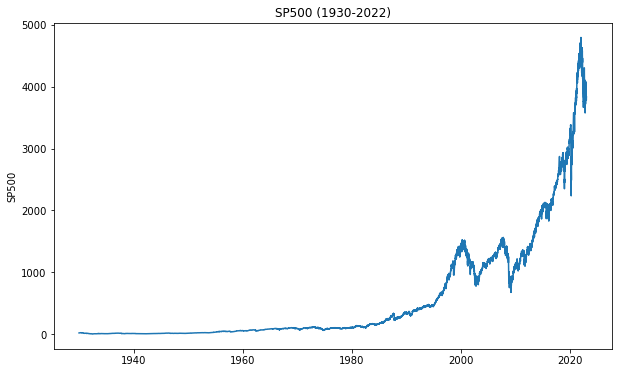

In [9]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(df['price']) 
# ax.plot(df) also works because there is only one column in the DataFrame
plt.ylabel('SP500')
plt.title('SP500 (1930-2022)')
fig.savefig('images/volatility_sp500.png')
plt.show()

- Compute the logarithmic returns.
- Remove the first missing row. 
- Rename the column "price" into "rets"
- Display the first 5 rows. 

In [10]:
rets = np.log(df / df.shift(1)).dropna() # rendement log 
rets.rename(columns={'price': 'rets'}, inplace=True)
rets.head()

rets
Date                
1930-01-03  0.002358
1930-01-04  0.011707
1930-01-06  0.000931
1930-01-07 -0.008876
1930-01-08 -0.000939

- Compute the volatility 

**"Classical formula"**: Volatility is computed as the standard deviation of the returns. To annualize volatility, multiply by the square root of data frequency. 

$$ \text{Volatility} = STD(R_t) $$ 

In [11]:
historical_volatility = np.std(rets) * np.sqrt(252)
historical_volatility

rets    0.182536
dtype: float64

Note: the <code>[0]</code> is needed in order to only get the number. 

In [12]:
historical_volatility = np.std(rets) * np.sqrt(252)
historical_volatility

rets    0.182536
dtype: float64

We can also use <code>['rets']</code>. 

In [13]:
historical_volatility = np.std(rets) * np.sqrt(252)
historical_volatility['rets']

0.1825362035297431

Alternatively, we can use the <code>.std()</code> method on the DataFrame. 

In [14]:
rets.std() * np.sqrt(252) 

rets    0.18254
dtype: float64

Finally, a nice output, we can use <code>format</code>. 

In [15]:
historical_volatility = np.std(rets) * np.sqrt(252)
historical_volatility = historical_volatility['rets']
print("{:.4%}".format(historical_volatility))

18.2536%


**"Finance formula"**: We can also make the simplifying assumption that $\bar{r} = 0$. In this case, the variance is simply the sum of the squared returns. 

$$ \sigma^2 = \frac{1}{m} \sum_{i=1}^m u^2_i $$ 

$$ \sigma = \sqrt{\sigma^2} $$ 

In [16]:
historical_volatility = np.sqrt(np.mean(rets**2, axis=0)) * np.sqrt(252) 
historical_volatility = historical_volatility[0]
print("{:.4%}".format(historical_volatility))

18.2568%


**Rolling volatility**

Volatility is not constant. Let's compute it and plot it using a rolling window of 252 days (approximately 1 year). 

In [17]:
rolling_vol = (rets.rolling(252).std()*np.sqrt(252))

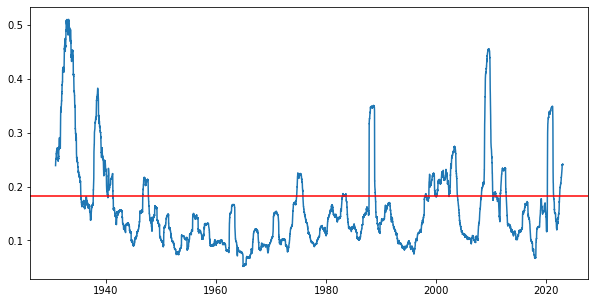

In [18]:
fig, ax = plt.subplots(figsize=(10,5))
ax.plot(rolling_vol)
plt.axhline(historical_volatility, color='red')
plt.savefig('images/volatility_rolling_window_volatility.png')
plt.show(); 

### EWMA 

Using the returns from 2010, use the EWMA to model volatility

To make things visual, we will put everything inside the DataFrame, very similar to what we would have done in Excel. 

In [19]:
rets = rets.loc['2010-01-01':].copy()
rets.head()

rets
Date                
2010-01-04  0.015910
2010-01-05  0.003118
2010-01-06  0.000540
2010-01-07  0.004000
2010-01-08  0.002876

Compute the number of observations and store this value in <code>n</code>.

In [20]:
n = rets.shape[0]
n

3272

Compute the squared returns and store it in a new column <code>rets_sq</code>.

In [21]:
rets['rets_sq'] = rets['rets']**2
rets

rets       rets_sq
Date                              
2010-01-04  0.015910  2.531178e-04
2010-01-05  0.003118  9.720487e-06
2010-01-06  0.000540  2.920861e-07
2010-01-07  0.004000  1.599607e-05
2010-01-08  0.002876  8.271171e-06
...              ...           ...
2022-12-23  0.005850  3.422799e-05
2022-12-27 -0.004057  1.645688e-05
2022-12-28 -0.012093  1.462353e-04
2022-12-29  0.017311  2.996689e-04
2022-12-30 -0.002546  6.480512e-06

[3272 rows x 2 columns]

Create a vector <code>conditional</code> of zero's with size <code>n</code> and add this vector in a column <code>conditional</code>. 

In [22]:
conditional = np.zeros(n)
rets['conditional'] = conditional
rets

rets       rets_sq  conditional
Date                                           
2010-01-04  0.015910  2.531178e-04          0.0
2010-01-05  0.003118  9.720487e-06          0.0
2010-01-06  0.000540  2.920861e-07          0.0
2010-01-07  0.004000  1.599607e-05          0.0
2010-01-08  0.002876  8.271171e-06          0.0
...              ...           ...          ...
2022-12-23  0.005850  3.422799e-05          0.0
2022-12-27 -0.004057  1.645688e-05          0.0
2022-12-28 -0.012093  1.462353e-04          0.0
2022-12-29  0.017311  2.996689e-04          0.0
2022-12-30 -0.002546  6.480512e-06          0.0

[3272 rows x 3 columns]

Initialize the second value as the squared value of the first return. 

In [23]:
# rets.iloc[1]['conditional'] = rets.iloc[0]['rets']**2
# this results in a warning 
rets.loc[rets.index[1], 'conditional'] = rets.iloc[0]['rets_sq']
rets

rets       rets_sq  conditional
Date                                           
2010-01-04  0.015910  2.531178e-04     0.000000
2010-01-05  0.003118  9.720487e-06     0.000253
2010-01-06  0.000540  2.920861e-07     0.000000
2010-01-07  0.004000  1.599607e-05     0.000000
2010-01-08  0.002876  8.271171e-06     0.000000
...              ...           ...          ...
2022-12-23  0.005850  3.422799e-05     0.000000
2022-12-27 -0.004057  1.645688e-05     0.000000
2022-12-28 -0.012093  1.462353e-04     0.000000
2022-12-29  0.017311  2.996689e-04     0.000000
2022-12-30 -0.002546  6.480512e-06     0.000000

[3272 rows x 3 columns]

Initialize a variable <code>lambda_val</code> with a value of 0.94. Then, implement this formula:

$$ \sigma^2_n = \lambda \sigma^2_{n-1} + (1 - \lambda) u^2_{n-1} $$ 

Note 1: <code>lambda</code> cannot be used as variable name as it has another signification in Python. 

Note 2: the vector <code>rets</code> has one additional observation in comparison to the vector <code>conditional</code>. 

In [24]:
lambda_val = 0.94

for t in range(2, n):
    rets.loc[rets.index[t], 'conditional'] = lambda_val * rets.iloc[t-1]['conditional'] \
                                             + (1 - lambda_val) * rets.iloc[t-1]['rets'] ** 2
        
rets.head()

rets       rets_sq  conditional
Date                                           
2010-01-04  0.015910  2.531178e-04     0.000000
2010-01-05  0.003118  9.720487e-06     0.000253
2010-01-06  0.000540  2.920861e-07     0.000239
2010-01-07  0.004000  1.599607e-05     0.000224
2010-01-08  0.002876  8.271171e-06     0.000212

Compute the loglikelihood as:
    
$$ \text{LogLikelihood}_i = - \ln(v_i) - \frac{u_i^2}{v_i} $$ 

where:
- $u_i$: return
- $v_i$: conditional 

In [25]:
rets.loc[rets.index[1:], 'likelihood'] = -np.log(rets.iloc[1:]['conditional']) \
                                         -((rets.iloc[1:]['rets']**2)/rets.iloc[1:]['conditional'])
rets.head()

rets       rets_sq  conditional  likelihood
Date                                                       
2010-01-04  0.015910  2.531178e-04     0.000000         NaN
2010-01-05  0.003118  9.720487e-06     0.000253    8.243253
2010-01-06  0.000540  2.920861e-07     0.000239    8.339858
2010-01-07  0.004000  1.599607e-05     0.000224    8.331539
2010-01-08  0.002876  8.271171e-06     0.000212    8.421147

Compute the sum of the log-likelihood into <code>log_likelihood</code>.

In [26]:
log_likelihood = rets['likelihood'].sum()
log_likelihood

27407.697995474882

Wrap everything within a function <code>ewma_pandas</code>, which takes two arguments: (1) the value of the lambda (<code>lambda_val</code>) and (2) the returns. This function returns the value of the loglikelihood. 

In [27]:
def ewma_pandas(lambda_val, rets):
    df = rets.copy()
    n = df.shape[0]
    df['rets_sq'] = df['rets']**2
    conditional = np.zeros(n)
    df['conditional'] = conditional
    df.loc[df.index[1], 'conditional'] = df.iloc[0]['rets']**2
    for t in range(2, n):
        df.loc[df.index[t], 'conditional'] = lambda_val * df.iloc[t-1]['conditional'] \
                                             + (1 - lambda_val) * df.iloc[t-1]['rets'] ** 2
    df.loc[df.index[1:], 'likelihood'] = -np.log(df.iloc[1:]['conditional']) \
                                         -((df.iloc[1:]['rets']**2)/df.iloc[1:]['conditional'])
    log_likelihood = df['likelihood'].sum()
    return -log_likelihood

In [28]:
df = pd.read_excel('data/sp500_daily.xlsx', index_col=0, parse_dates=True)
rets = np.log(df/df.shift(1)).dropna()
rets.rename(columns={'CLOSE':'rets'}, inplace=True)
rets = rets.loc['2010-01-01':]
rets

rets
Date                
2010-01-04  0.015910
2010-01-05  0.003118
2010-01-06  0.000540
2010-01-07  0.004000
2010-01-08  0.002876
...              ...
2022-12-23  0.005850
2022-12-27 -0.004057
2022-12-28 -0.012093
2022-12-29  0.017311
2022-12-30 -0.002546

[3272 rows x 1 columns]

- Call this function with a lambda value of 0.94. You should find the same value. 

In [29]:
rets

ewma_pandas(0.94, rets)

-27407.697995474882

### Naive optimization

For different values of lambda between 0.80 and 1.00, compute the value of the different loglikelihood and plot it. 

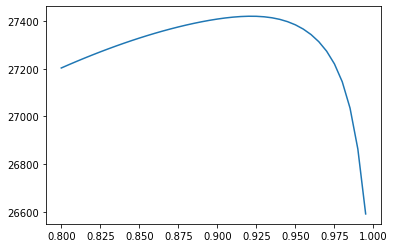

In [30]:
lambda_vals = np.arange(0.80, 1, 0.005)
log_vals = [-ewma_pandas(lam, rets) for lam in lambda_vals]
plt.plot(lambda_vals, log_vals);

We notice a maximum around 0.925. Let's now optimize it to find the actual answer. 

In [31]:
# reinitialize dataframe 
rets = np.log(df / df.shift(1)).dropna() # rendement log 
rets.rename(columns={'CLOSE': 'rets'}, inplace=True)
rets = rets.loc['2010-01-01':].copy()

var = np.std(rets)**2 # historical variance 
res = spop.minimize(ewma_pandas, var, rets, method="Nelder-Mead")
params = res.x
function = res.fun
print('Parameters: ', res.x)
print('LogLikelihood: ', -res.fun)

Parameters:  [0.92171991]
LogLikelihood:  27420.928807446242


In [32]:
lambda_val = res.x
df = rets.copy()
n = df.shape[0]
df['rets_sq'] = df['rets']**2
conditional = np.zeros(n)
df['conditional'] = conditional
df.loc[df.index[1], 'conditional'] = df.iloc[0]['rets']**2
for t in range(2, n):
    df.loc[df.index[t], 'conditional'] = lambda_val * df.iloc[t-1]['conditional'] \
                                         + (1 - lambda_val) * df.iloc[t-1]['rets'] ** 2

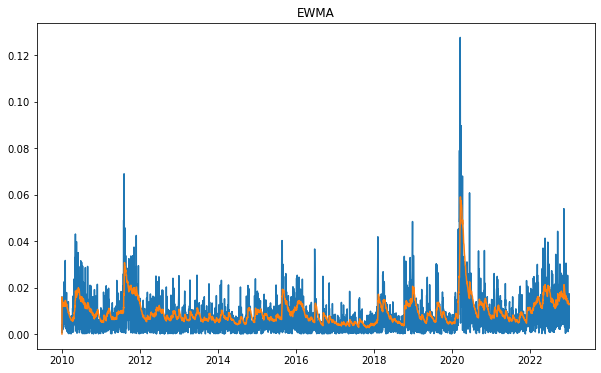

In [33]:
fig, ax = plt.subplots(figsize=(10,6))
ax.plot(np.abs(df['rets']))
ax.plot(df['conditional']**(1/2))
ax.set_title('EWMA')
plt.show()

In [34]:
%%time 

ewma_pandas(0.94, rets)

CPU times: user 447 ms, sys: 1.57 ms, total: 449 ms
Wall time: 448 ms


-27407.697995474882

### Improve performance using numpy 

It is not easy nor efficient to fill a DataFrame. A better approach (although less beautiful) is to work with numpy arrays. Reimplement everything without using Pandas. 

In [35]:
df = pd.read_excel('data/sp500_daily.xlsx', index_col=0, parse_dates=True)
rets = np.log(df / df.shift(1)).dropna() # rendement log 
rets.rename(columns={'CLOSE': 'rets'}, inplace=True)
rets = rets.loc['2010-01-01':]
rets = np.array(rets).ravel()
rets.shape
rets

array([ 0.01590968,  0.00311777,  0.00054045, ..., -0.01209278,
        0.01731095, -0.00254568])

In [36]:
n = len(rets)
n

3272

In [37]:
conditional = np.zeros(n-1)
conditional[0] = rets[0]**2
conditional

array([0.00025312, 0.        , 0.        , ..., 0.        , 0.        ,
       0.        ])

In [38]:
lambda_val = 0.94

for t in range(1, len(conditional)):
    conditional[t] = lambda_val * conditional[t-1] + (1 - lambda_val) * rets[t] ** 2
        
conditional

array([0.00025312, 0.00023851, 0.00022422, ..., 0.00017394, 0.00017228,
       0.00017992])

In [39]:
likelihood = -np.log(conditional)-((rets[1:]**2)/conditional)
likelihood

array([8.24325261, 8.33985817, 8.33153924, ..., 7.81607462, 6.92696348,
       8.58695739])

In [40]:
log_likelihood = np.sum(likelihood)
log_likelihood

27407.697995474882

It's now time to wrap everything within a function <code>ewma</code>. We assume that we pass to the function two arguments: 
- the value of the lambda
- a series of return in a ndarray

In [41]:
rets = np.array(rets)

In [42]:
def ewma_numpy(lambda_val, rets):
    n = len(rets)
    conditional = np.zeros(n-1)
    conditional[0] = rets[0]**2 
    for t in range(1, len(conditional)):
        conditional[t] = lambda_val * conditional[t-1] + (1 - lambda_val) * rets[t] ** 2
    likelihood = -np.log(conditional)-((rets[1:]**2)/conditional)
    log_likelihood = np.sum(likelihood)
    return -log_likelihood

Let's check we get the same value of the logLikelihood using the function. 

In [43]:
%%time 

ewma_numpy(lambda_val=0.94, rets=rets)

CPU times: user 2.42 ms, sys: 269 µs, total: 2.69 ms
Wall time: 2.49 ms


-27407.697995474882

It's now time to optimize the function using <code>spop.minimize</code>. 

In [44]:
var = np.std(rets)**2 # historical variance 
res = spop.minimize(ewma_numpy, [var], rets, method="Nelder-Mead")
params = res.x
function = res.fun
print('Parameters: ', res.x)
print('LogLikelihood: ', -res.fun)

Parameters:  [0.92171991]
LogLikelihood:  27420.928807446242


## GARCH Modelling (NEDL)

Now it's your turn to implement the GARCH method. 

In [45]:
df = pd.read_excel('data/sp500_daily.xlsx', index_col=0, parse_dates=True)
rets = np.log(df / df.shift(1)).dropna()
rets.rename(columns={'CLOSE': 'rets'}, inplace=True)
rets = rets.loc['2010-01-01':].copy()
rets = np.array(rets)
rets = rets.ravel()
mean = np.average(rets)
var = np.var(rets)

In [46]:
def garch_nedl(params):
    mu = params[0]
    omega = params[1]
    alpha = params[2]
    beta = params[3]
    long_run = (omega/(1-alpha-beta))**(1/2)
    resid = rets - mu
    realised = abs(resid)
    conditional = np.zeros(len(rets))
    conditional[0] = long_run
    for t in range(1, len(rets)):
        conditional[t] = (omega + alpha*resid[t-1]**2 + beta*conditional[t-1]**2)**(1/2)
    likelihood = 1/((2*np.pi)**(1/2)*conditional)*np.exp(-realised**2/(2*conditional**2))
    log_likelihood = np.sum(np.log(likelihood))
    return -log_likelihood

In [47]:
#bnds = tuple((0,1) for x in range(4))
res = spop.minimize(garch_nedl, [mean, var, 0, 0], 
                    #bounds=bnds, 
                    method='Nelder-Mead')
params = res.x
mu = params[0]
omega = params[1]
alpha = params[2]
beta = params[3]
long_run = (omega/(1-alpha-beta))**(1/2)
resid = rets - mu
realised = abs(resid)
conditional = np.zeros(len(rets))
conditional[0] = long_run
for t in range(1, len(rets)):
    conditional[t] = (omega + alpha*resid[t-1]**2 + beta*conditional[t-1]**2)**(1/2)
    
print('GARCH model parameters')
print('----------------------')
print('mu', str(round(mu, 6)))
print('omega', str(round(omega, 6)))
print('alpha', str(round(alpha, 6)))
print('beta', str(round(beta, 6)))

GARCH model parameters
----------------------
mu 0.000775
omega 4e-06
alpha 0.178418
beta 0.793665


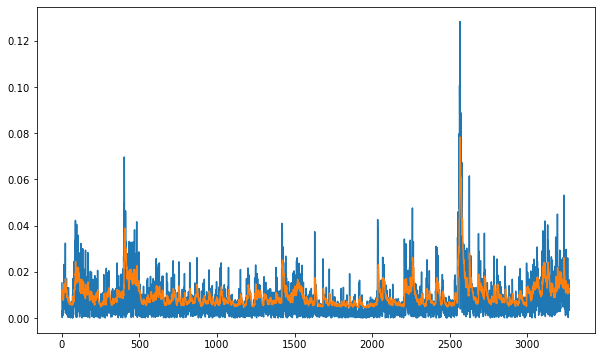

In [48]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(realised)
ax.plot(conditional)

### Garch zero-mean

In [49]:
def garch_zero_mean(params):
    # specifying model parameters
    mu = 0 
    omega = params[0]
    alpha = params[1]
    beta = params[2]
    # calculating long run volatility
    # long_run = (omega/(1 - alpha - beta))**(1/2)
    # calculating realized and conditional volatility
    resid = rets - mu
    realized = abs(resid)
    conditional = np.zeros(len(rets))
    conditional[0] = rets[0]**2
    for t in range(1, len(rets)):
        conditional[t] = (omega + alpha*resid[t-1]**2 + beta*conditional[t-1])
    # calculating loglikelihood
    likelihood = -np.log(conditional) - realized**2 / conditional
    log_likelihood = np.sum(likelihood)
    return -log_likelihood

In [50]:
#mean = np.average(returns)
var = np.std(rets)**2
bounds = [(0.0, 1.0)]*3

In [51]:
res = spop.minimize(garch_zero_mean, [var, 0, 0], bounds=bounds, method='Nelder-Mead')
mu = 0 
omega = res.x[0]
alpha = res.x[1]
beta = res.x[2]
log_likelihood = -float(res.fun)
# calculating realized and conditional volatility
# long_run = (omega/(1 - alpha - beta))**(1/2)
resid = rets - mu
realized = abs(resid)
conditional = np.zeros(len(rets))
conditional[0] = rets[0]**2
for t in range(1, len(rets)):
    conditional[t] = (omega + alpha*resid[t-1]**2 + beta*conditional[t-1]**2)**(1/2)

likelihood = -np.log(conditional) - realized**2 / conditional
log_likelihood = np.sum(likelihood)

print('GARCH model parameters')
print('----------------------')
print('mu', str(round(mu, 6)))
print('omega', str(round(omega, 6)))
print('alpha', str(round(alpha, 6)))
print('beta', str(round(beta, 6)))
# print('long-run volatility', str(round(long_run, 4)))
print('log-likelihood', str(round(log_likelihood, 4))) 

GARCH model parameters
----------------------
mu 0
omega 7.7e-05
alpha 0.385073
beta 0.0
log-likelihood 14968.3621


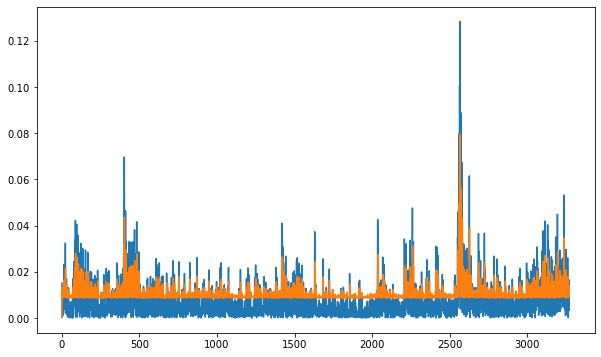

In [52]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(realised)
ax.plot(conditional)

## ARCH package

https://arch.readthedocs.io/en/latest/index.html

In [53]:
# !pip install arch
from arch import arch_model

In [54]:
am = arch_model(rets*100)
res = am.fit()
print(res.summary())

Iteration:      1,   Func. Count:      6,   Neg. LLF: 45190.138944107726
Iteration:      2,   Func. Count:     17,   Neg. LLF: 19000.159297830152
Iteration:      3,   Func. Count:     27,   Neg. LLF: 6719.894415448125
Iteration:      4,   Func. Count:     34,   Neg. LLF: 8186.897239907136
Iteration:      5,   Func. Count:     40,   Neg. LLF: 4525.832689694671
Iteration:      6,   Func. Count:     47,   Neg. LLF: 4243.099399974918
Iteration:      7,   Func. Count:     53,   Neg. LLF: 4241.2416896886125
Iteration:      8,   Func. Count:     58,   Neg. LLF: 4241.24076531225
Iteration:      9,   Func. Count:     63,   Neg. LLF: 4241.240763542724
Iteration:     10,   Func. Count:     67,   Neg. LLF: 4241.240763542601
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4241.240763542724
            Iterations: 10
            Function evaluations: 67
            Gradient evaluations: 10
                     Constant Mean - GARCH Model Results             

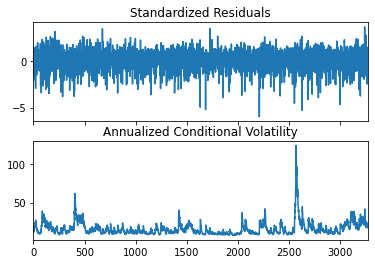

In [55]:
fig = res.plot(annualize="D")

## References and further ressources

NEDL - ARCH model - volatility persistence in time series (Excel)

https://www.youtube.com/watch?v=-G5g3ChktEs

NEDL - GARCH model - volatility persistence in time series (Excel)

https://www.youtube.com/watch?v=88oOzPFVWTU

NEDL - GARCH model in Python

https://www.youtube.com/watch?v=3boMYvIzGQ8